In [1]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist['data']     # shape: (70000, 784)
y = mnist['target']   # shape: (70000,), string labels

X = X.astype(np.float32) / 255.0
y = y.astype(np.int64)

/home/yicheng/anaconda3/envs/machine_learning_minst/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


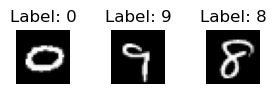

In [2]:
import matplotlib.pyplot as plt
import numpy as np

idxs = np.random.choice(len(X), 3, replace=False)

plt.figure(figsize=(3,1))

for i, idx in enumerate(idxs):
    img = X[idx].reshape(28, 28)
    label = y[idx]

    plt.subplot(1,3,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0], 1), dtype=np.float32)]) # (60000, 785)
X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0], 1), dtype=np.float32)]) # (10000, 785)

D = X_train_bias.shape[1] # 785
num_classes = 10

def to_one_hot(y, num_classes=10):
    # y: (N,) -> 返回 (N, num_classes)
    return np.eye(num_classes, dtype=np.float32)[y]

Y_train = to_one_hot(y_train, num_classes) # (60000, 10)
Y_test = to_one_hot(y_test, num_classes) # (10000, 10)

In [4]:
# 闭式解：W = (X^T X)^(-1) X^T Y
# X: (60000, 785)  Y: (60000, 10)  ->  W: (785, 10)

XtX = X_train_bias.T @ X_train_bias
XtY = X_train_bias.T @ Y_train

# 使用伪逆
W_closed = np.linalg.pinv(XtX) @ XtY

In [5]:
Y_train_pred = X_train_bias @ W_closed # (60000, 10)
Y_test_pred = X_test_bias @ W_closed # (10000, 10)

y_train_pred = np.argmax(Y_train_pred, axis=1) #(60000,)
y_test_pred = np.argmax(Y_test_pred, axis=1) # (10000,)

train_acc = np.mean(y_train_pred == y_train)
test_acc = np.mean(y_test_pred == y_test)

print(f"Train accuracy（闭式解）: {train_acc:.4f}")
print(f"Test accuracy（闭式解）: {test_acc:.4f}")

Train accuracy（闭式解）: 0.8577
Test accuracy（闭式解）: 0.8603


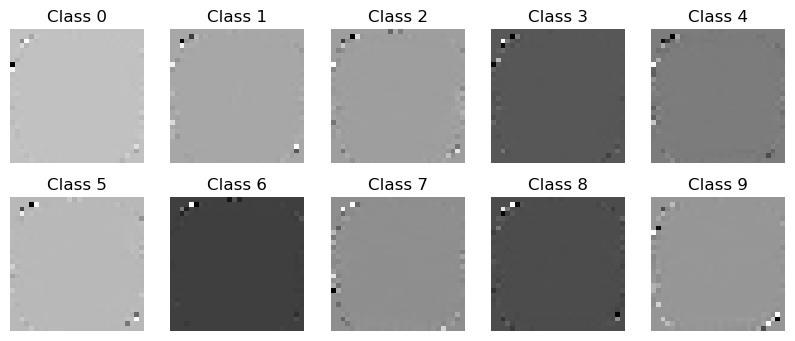

In [6]:
# 可视化
W_img = W_closed[:-1].T.reshape(10,28,28)

plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(W_img[i], cmap='gray')
    plt.title(f"Class {i}")
    plt.axis("off")
plt.show()

In [7]:
import numpy as np

def to_one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

def linear_regression_gd(X:np.array, y, lr=0.1, epoches=50):
    """
    X: (N, 784)
    y: (N,)
    """
    X_bias = np.hstack([X, np.ones((X.shape[0],1))])

    N,D = X_bias.shape
    num_classes = 10

    Y = to_one_hot(y, num_classes)

    # 初始化权重
    W = np.zeros((D, num_classes), dtype=np.float32) #(D, 10)

    for epoch in range(epoches):
        # 前向传播
        Y_pred = X_bias @ W # (N,10)

        # 梯度
        grad = (X_bias.T @ (Y_pred-Y)) / N #(D,10)

        # 更新
        W -= lr*grad

        # 损失
        loss = 0.5 * np.mean((Y_pred-Y)**2)
        if (epoch+1) % 100 == 0:
            print(f"epoch {epoch+1}/{epoches}, Loss = {loss:.6f}")
    
    return W

In [ ]:
# 使用梯度下降进行线性回归
W_iter = linear_regression_gd(X_train, y_train, lr=0.01, epoches=1000)

X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0],1))])
Y_train_pred = X_train_bias @ W_iter # (D, 10)
y_train_pred = np.argmax(Y_train_pred, axis=1)

X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0],1))])
Y_test_pred = X_test_bias @ W_iter
y_test_pred = np.argmax(Y_test_pred, axis=1)

train_acc = np.mean(y_train_pred == y_train)
test_acc = np.mean(y_test_pred == y_test)

print("Iterative GD Train Accuracy:", train_acc)
print("Iterative GD Test Accuracy:", test_acc)

epoch 100/1000, Loss = 0.024513
epoch 200/1000, Loss = 0.022656
epoch 300/1000, Loss = 0.021914
epoch 400/1000, Loss = 0.021492
epoch 500/1000, Loss = 0.021207
epoch 600/1000, Loss = 0.020995
epoch 700/1000, Loss = 0.020829
epoch 800/1000, Loss = 0.020693
epoch 900/1000, Loss = 0.020579
epoch 1000/1000, Loss = 0.020482
Iterative GD Train Accuracy: 0.8527
Iterative GD Test Accuracy: 0.8601


In [24]:
import numpy as np

def to_one_hot(y, num_classes=10):
    return np.eye(num_classes)[y]

def linear_regression_gd_minibatch(X,y,lr=0.01,batch_size=128,epoches=10,shuffle=True):
    X_bias = np.hstack([X, np.ones((X.shape[0],1), dtype=np.float32)])
    
    N, D = X_bias.shape
    num_classes = 10
    Y = to_one_hot(y, num_classes)  # (N, 10)

    W = np.zeros((D, num_classes), dtype=np.float32)

    epoch = 0
    while epoch < epoches:
        if shuffle:
            indices = np.random.permutation(N)
        else:
            indices = np.arange(N)
        
        for start in range(0, N, batch_size):
            end = start + batch_size
            batch_idx = indices[start:end]

            X_batch = X_bias[batch_idx]
            Y_batch = Y[batch_idx]
            B = X_batch.shape[0]

            Y_pred_batch = X_batch @ W

            grad = X_batch.T @ (Y_pred_batch - Y_batch) / B
            W -= lr * grad
            epoch += 1

            if (epoch+1) % 100 == 0:
                Y_pred = X_bias @ W
                loss = 0.5 * np.mean((Y_pred - Y) ** 2)
                print(f"epoch {epoch+1}/{epoches}, Loss = {loss:.6f}")
            if epoch > epoches:
                break
    
    return W

In [25]:
# 使用梯度下降进行线性回归
W_iter = linear_regression_gd_minibatch(X_train, y_train, lr=0.01, epoches=1000)

X_train_bias = np.hstack([X_train, np.ones((X_train.shape[0],1))])
Y_train_pred = X_train_bias @ W_iter # (D, 10)
y_train_pred = np.argmax(Y_train_pred, axis=1)

X_test_bias = np.hstack([X_test, np.ones((X_test.shape[0],1))])
Y_test_pred = X_test_bias @ W_iter
y_test_pred = np.argmax(Y_test_pred, axis=1)

train_acc = np.mean(y_train_pred == y_train)
test_acc = np.mean(y_test_pred == y_test)

print("Iterative GD-batch Train Accuracy:", train_acc)
print("Iterative GD-batch Test Accuracy:", test_acc)

epoch 100/1000, Loss = 0.024515
epoch 200/1000, Loss = 0.022693
epoch 300/1000, Loss = 0.021961
epoch 400/1000, Loss = 0.021574
epoch 500/1000, Loss = 0.021271
epoch 600/1000, Loss = 0.021047
epoch 700/1000, Loss = 0.020878
epoch 800/1000, Loss = 0.020766
epoch 900/1000, Loss = 0.020626
epoch 1000/1000, Loss = 0.020528
Iterative GD-batch Train Accuracy: 0.8515666666666667
Iterative GD-batch Test Accuracy: 0.8596
